# Importing Libraries

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
!pip install imperio
import imperio
import tensorflow as tf
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz, process

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import data

In [52]:
df = pd.read_csv('/content/drive/MyDrive/Organizatii/Sigmoid/Padawan Learning/Exam/data2.csv')

In [53]:
df

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.00,263.00,62,0.01,71.28,65.00,1154,...,6.00,8.16,65.00,0.10,584.26,33736494.00,17.20,17.30,0.48,10.10
1,Afghanistan,2014,Developing,59.90,271.00,64,0.01,73.52,62.00,492,...,58.00,8.18,62.00,0.10,612.70,327582.00,17.50,17.50,0.48,10.00
2,Afghanistan,2013,Developing,59.90,268.00,66,0.01,73.22,64.00,430,...,62.00,8.13,64.00,0.10,631.74,31731688.00,17.70,17.70,0.47,9.90
3,Afghanistan,2012,Developing,59.50,272.00,69,0.01,78.18,67.00,2787,...,67.00,8.52,67.00,0.10,669.96,3696958.00,17.90,18.00,0.46,9.80
4,Afghanistan,2011,Developing,59.20,275.00,71,0.01,7.10,68.00,3013,...,68.00,7.87,68.00,0.10,63.54,2978599.00,18.20,18.20,0.45,9.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.30,723.00,27,4.36,0.00,68.00,31,...,67.00,7.13,65.00,33.60,454.37,12777511.00,9.40,9.40,0.41,9.20
2934,Zimbabwe,2003,Developing,44.50,715.00,26,4.06,0.00,7.00,998,...,7.00,6.52,68.00,36.70,453.35,12633897.00,9.80,9.90,0.42,9.50
2935,Zimbabwe,2002,Developing,44.80,73.00,25,4.43,0.00,73.00,304,...,73.00,6.53,71.00,39.80,57.35,125525.00,1.20,1.30,0.43,10.00
2936,Zimbabwe,2001,Developing,45.30,686.00,25,1.72,0.00,76.00,529,...,76.00,6.16,75.00,42.10,548.59,12366165.00,1.60,1.70,0.43,9.80


# Analizing

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

There could be observed that Some coulmns (Population, GDP, Hepatitis B) has significant number of NaN data

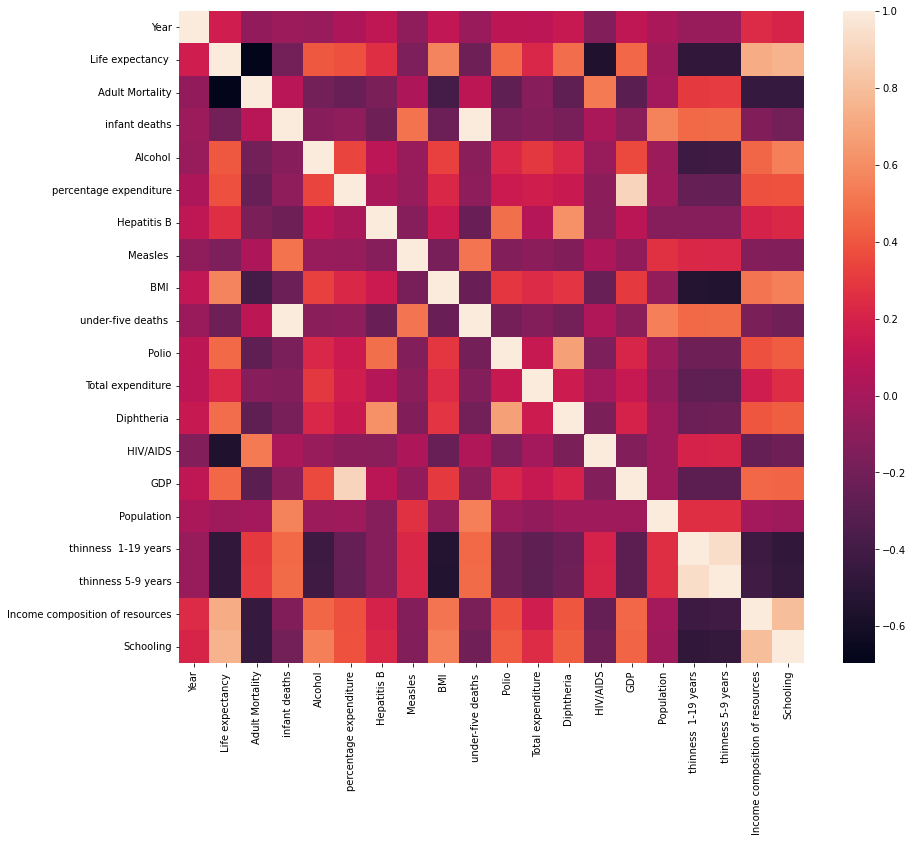

In [55]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr())
plt.show()

"thinness 5-9" is repeating in "thinness 1-19"

In [56]:
status_groupby = df.groupby('Status', as_index=False)
status_groupby['Life expectancy '].describe()

Status  0     Developed
        1    Developing
count   0        512.00
        1       2416.00
mean    0         79.20
        1         67.11
std     0          3.93
        1          9.01
min     0         69.90
        1         36.30
25%     0         76.80
        1         61.10
50%     0         79.25
        1         69.00
75%     0         81.70
        1         74.00
max     0         89.00
        1         89.00
dtype: object

From the above table there could be possible to extract following information:


1.   There are less Developed countries than in the process. 
2.   The variation of life expectancy in the countries that are in process of developing  is bigger. 



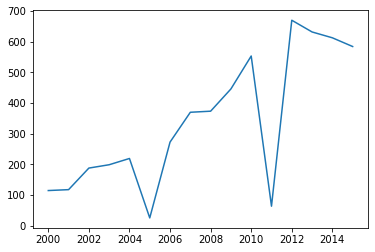

In [57]:
# Get random data of a country
data_Afganistan = df[df['Country'] == 'Afghanistan']

# Plot GDP per years
plt.plot(data_Afganistan['Year'].astype(int), data_Afganistan['GDP'])

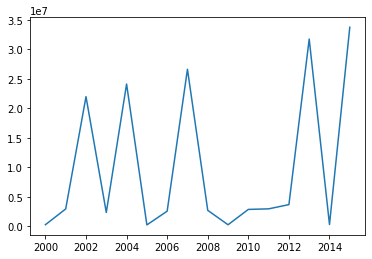

In [58]:
# Plot population per years
plt.plot(data_Afganistan['Year'].astype(int), data_Afganistan['Population'])

The real population of Afhanistan in 2015 was 33 millions (source: Wikipedia).
This means that data in the following years [2014, 2010,2008,2006, 2005,2003,2001,2000] is wrong, because it has an enormous deviation.

From the above graph we can see that there is a problem in data. The person who entered the data made mistakes in entering the data, sometimes not adding a digit to the number, for example instead of 36043432, he entered only 3604343, and respectively the number is 10 times smaller than the initial one, as a result it creates enormous disturbances in dataset.

### Plot populatation of multiple countries

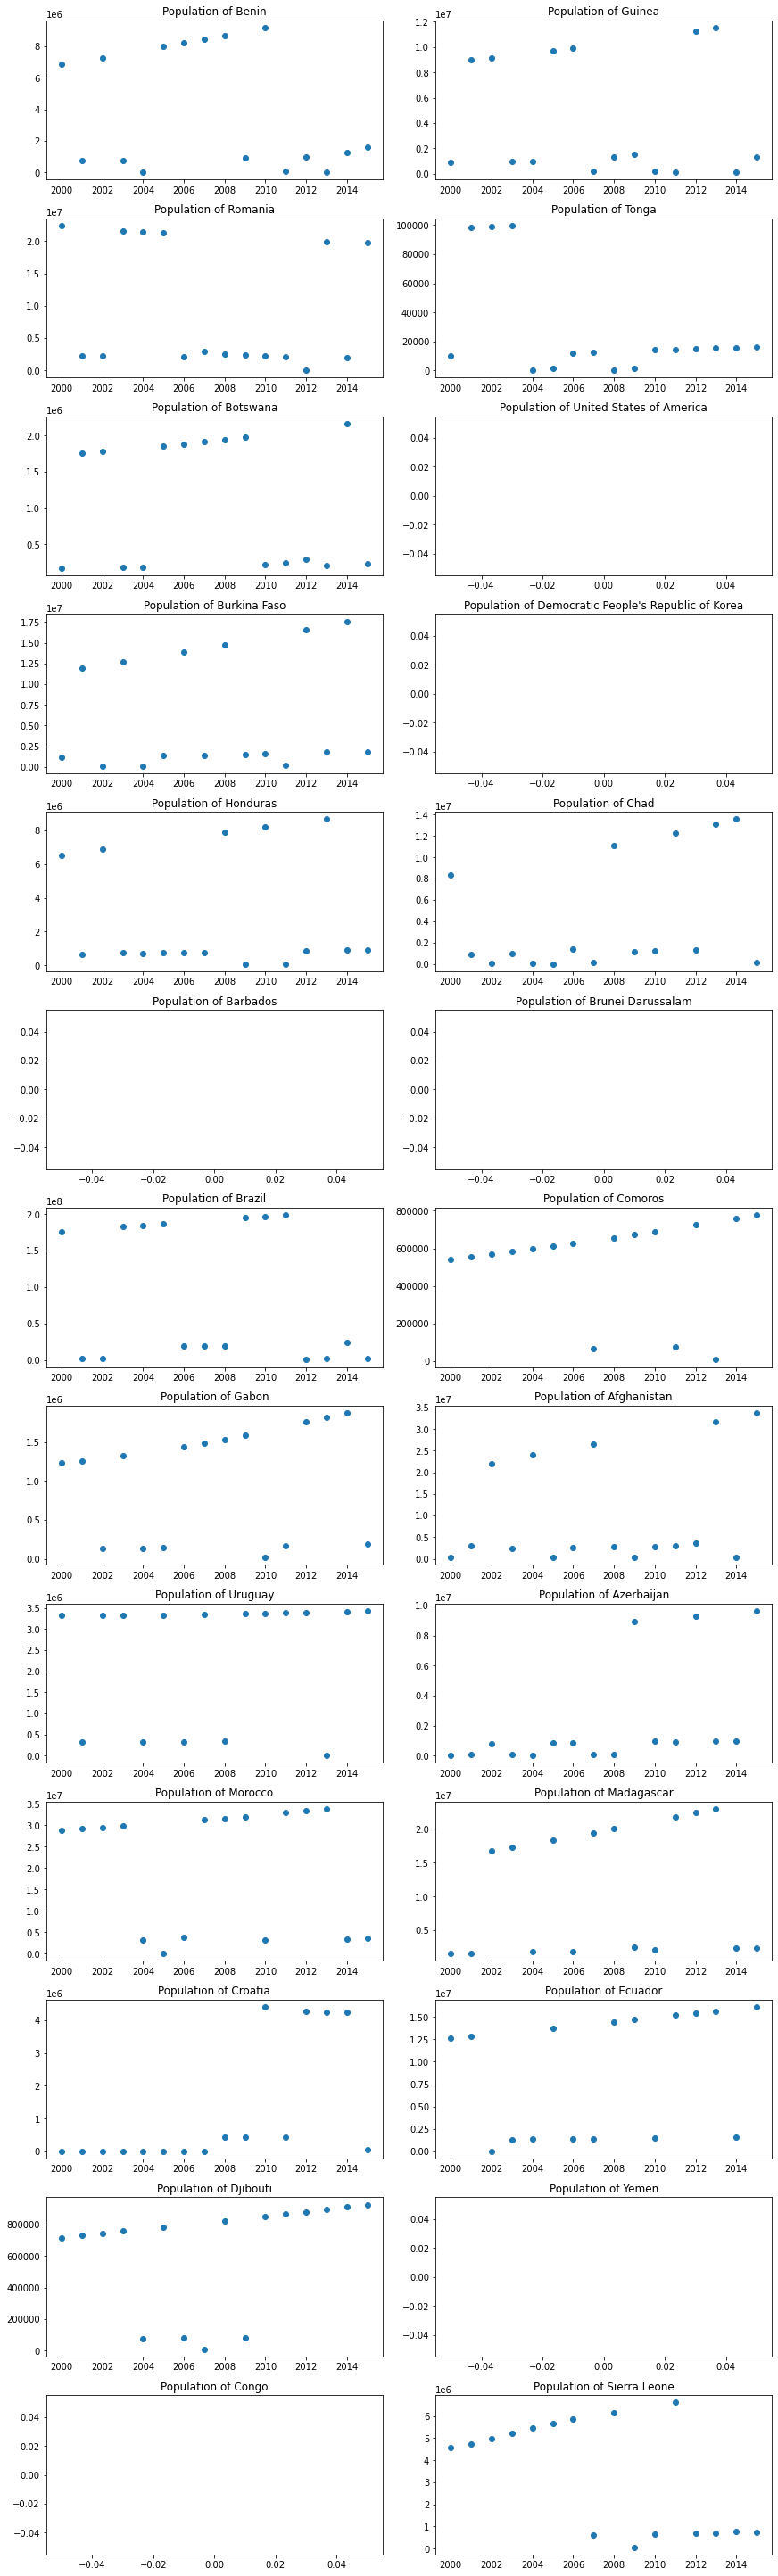

In [59]:
# Plot Population of 26 countries

# Get random 26 countries
countries_to_analyze = df['Country'].sample(n=26).values

# Per each country plot population and outliers.

x = y = 0 # coordinates for plot
fig, axs = plt.subplots(13, 2, figsize=(12, 40), constrained_layout=True)

for country in countries_to_analyze:
    # Get all 15 rows (15 years) for selected country
    df_country = df[df['Country'] == country]

    # Ploting data
    axs[x,y].set_title(f'Population of {country}')
    axs[x,y].scatter(df_country['Year'].astype(int), df_country['Population'])

    # Changing coordinates for ploting on next graph
    if y == 0:
        y = 1
    else:
        y = 0
        x += 1

We can see that the problem lies in most countries.
For example, in Greece the population in 2015 was 10.86 million people, but in the graph only 1 million is represented (10 times smaller). Respectively, only one year (2010) has the correct number, the rest have the mistake.

### Plot GDP of multiple countries

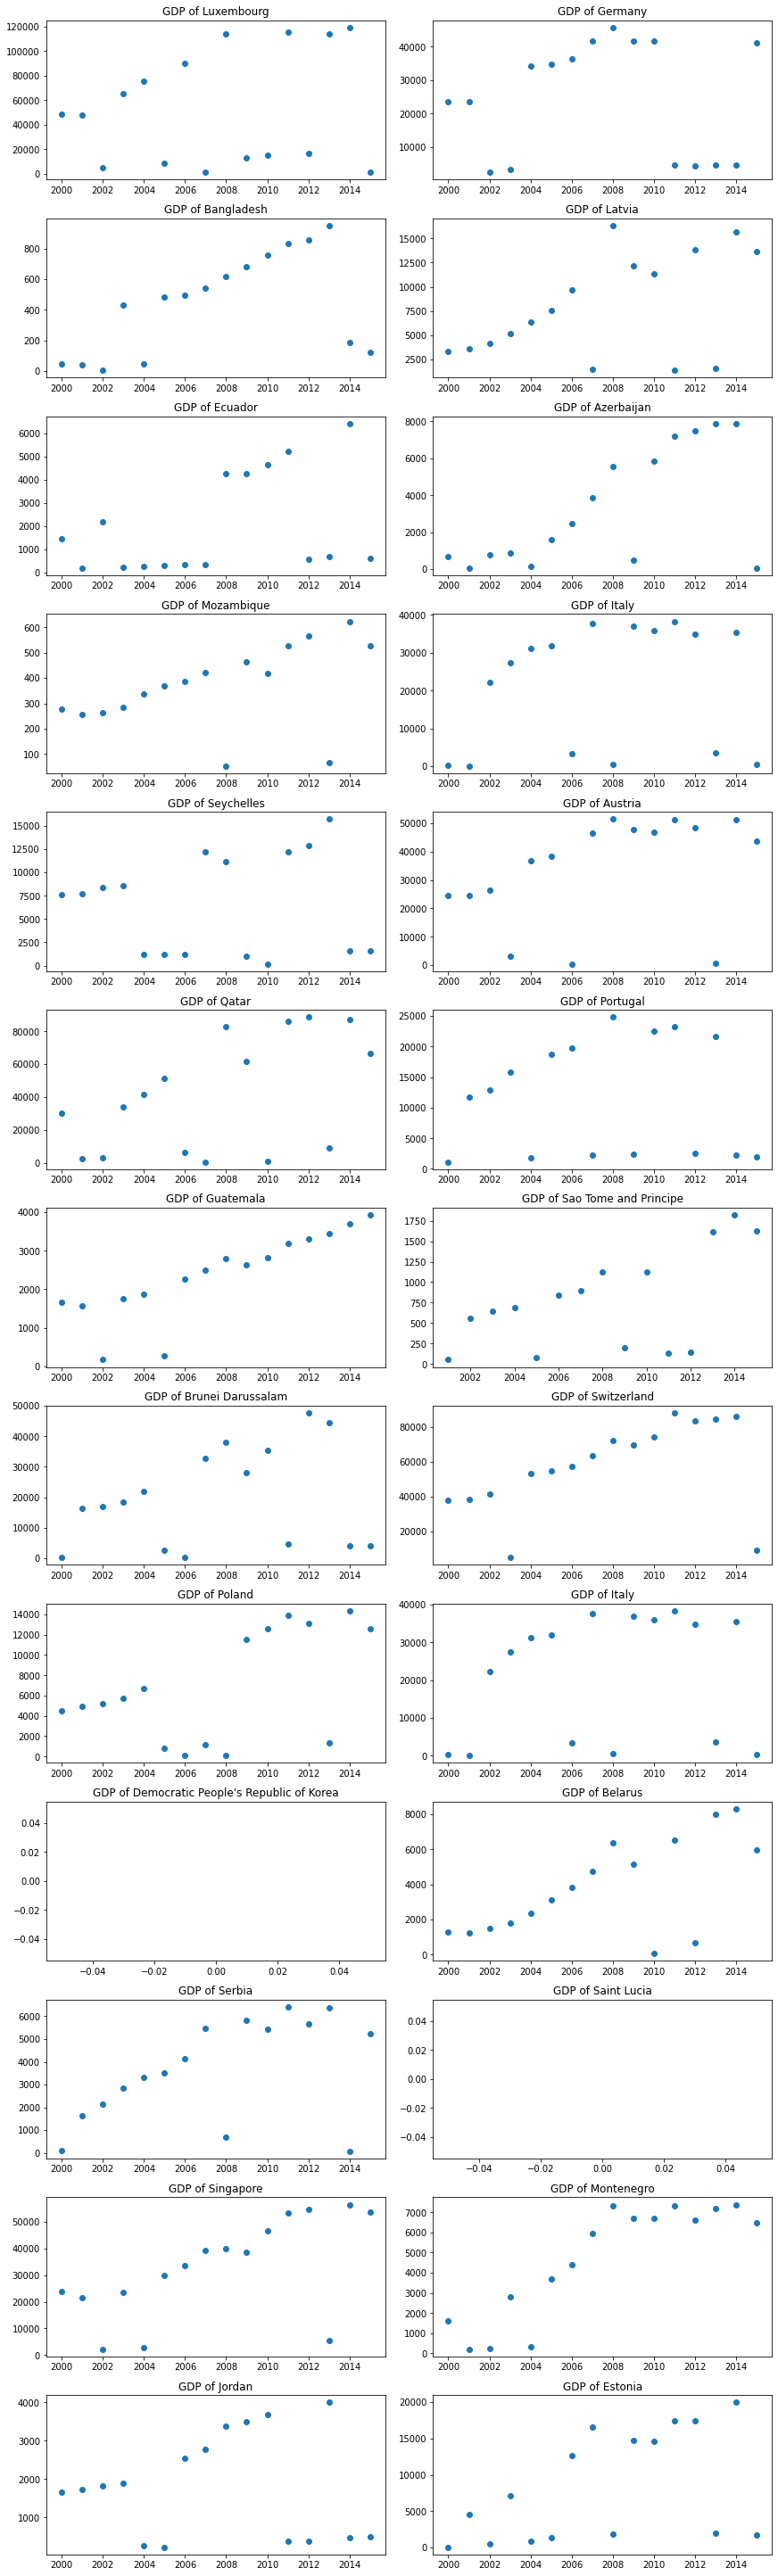

In [60]:
# Plot GDP of 26 countries

# Get random 26 countries
countries_to_analyze = df['Country'].sample(n=26).values

# Per each country plot population and outliers.

x = y = 0 # coordinates for plot
fig, axs = plt.subplots(13, 2, figsize=(12, 40), constrained_layout=True)

for country in countries_to_analyze:
    # Get all 15 rows (15 years) for selected country
    df_country = df[df['Country'] == country]

    # Ploting data
    axs[x,y].set_title(f'GDP of {country}')
    axs[x,y].scatter(df_country['Year'].astype(int), df_country['GDP'])

    # Changing coordinates for ploting on next graph
    
    if y == 0:
        y = 1
    else:
        y = 0
        x += 1

# Preprocessing

In [61]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [62]:
# Remove white spaces in column names
df.columns = df.columns.str.strip()

In [63]:
# drop thinness 5-9
df.drop(['thinness 5-9 years'], axis=1, inplace=True)

## Dealing with non-valid data  (GDP and Population)

#### Population 

In [64]:
# Import a new csv file from World Bank Data
population_df = pd.read_csv('/content/drive/MyDrive/Organizatii/Sigmoid/Padawan Learning/Exam/World_Bank_Data_Population.csv', error_bad_lines=False, header=2)
population_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.00,55811.00,56682.00,57475.00,58178.00,58782.00,...,102880.00,103594.00,104257.00,104874.00,105439.00,105962.00,106442.00,106585.00,106537.00,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579.00,134169237.00,137835590.00,141630546.00,145605995.00,149742351.00,...,567891875.00,583650827.00,600008150.00,616377331.00,632746296.00,649756874.00,667242712.00,685112705.00,702976832.00,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466.00,8790140.00,8969047.00,9157465.00,9355514.00,9565147.00,...,31541209.00,32716210.00,33753499.00,34636207.00,35643418.00,36686784.00,37769499.00,38972230.00,40099462.00,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290.00,99314028.00,101445032.00,103667517.00,105959979.00,108336203.00,...,387204553.00,397855507.00,408690375.00,419778384.00,431138704.00,442646825.00,454306063.00,466189102.00,478185907.00,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195.00,5441333.00,5521400.00,5599827.00,5673199.00,5736582.00,...,26147002.00,27128337.00,28127721.00,29154746.00,30208628.00,31273533.00,32353588.00,33428486.00,34503774.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,"Population, total",SP.POP.TOTL,947000.00,966000.00,994000.00,1022000.00,1050000.00,1078000.00,...,1818117.00,1812771.00,1788196.00,1777557.00,1791003.00,1797085.00,1788878.00,1790133.00,1786038.00,NaN
262,"Yemen, Rep.",YEM,"Population, total",SP.POP.TOTL,5542459.00,5646668.00,5753386.00,5860197.00,5973803.00,6097298.00,...,26984002.00,27753304.00,28516545.00,29274002.00,30034389.00,30790513.00,31546691.00,32284046.00,32981641.00,NaN
263,South Africa,ZAF,"Population, total",SP.POP.TOTL,16520441.00,16989464.00,17503133.00,18042215.00,18603097.00,19187194.00,...,53873616.00,54729551.00,55876504.00,56422274.00,56641209.00,57339635.00,58087055.00,58801927.00,59392255.00,NaN
264,Zambia,ZMB,"Population, total",SP.POP.TOTL,3119430.00,3219451.00,3323427.00,3431381.00,3542764.00,3658024.00,...,15234976.00,15737793.00,16248230.00,16767761.00,17298054.00,17835893.00,18380477.00,18927715.00,19473125.00,NaN


From the above (new dataset) we can see that it contains total population of each county per years. 

Now we need to extract data from the new dataset and assign it to the previous one

In [65]:
population_df.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       'Unnamed: 66'],
      dtype='object')

In [66]:
# Drop Non-Usable columns
population_droped_df = population_df.drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 66'], axis=1)

# Drop Age-Columns that are out of our scope
population_droped_df = population_droped_df.drop(
    [i for i in population_droped_df.columns[1:] if int(i) < 2000 or int(i) > 2015],
    axis=1)

population_droped_df

,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Aruba,89101.00,90691.00,91781.00,92701.00,93540.00,94483.00,95606.00,96787.00,97996.00,99212.00,100341.00,101288.00,102112.00,102880.00,103594.00,104257.00
1,Africa Eastern and Southern,401600588.00,412001885.00,422741118.00,433807484.00,445281555.00,457153837.00,469508516.00,482406426.00,495748900.00,509410477.00,523459657.00,537792950.00,552530654.00,567891875.00,583650827.00,600008150.00
2,Afghanistan,19542982.00,19688632.00,21000256.00,22645130.00,23553551.00,24411191.00,25442944.00,25903301.00,26427199.00,27385307.00,28189672.00,29249157.00,30466479.00,31541209.00,32716210.00,33753499.00
3,Africa Western and Central,269611898.00,277160097.00,284952322.00,292977949.00,301265247.00,309824829.00,318601484.00,327612838.00,336893835.00,346475221.00,356337762.00,366489204.00,376797999.00,387204553.00,397855507.00,408690375.00
4,Angola,16394062.00,16941587.00,17516139.00,18124342.00,18771125.00,19450959.00,20162340.00,20909684.00,21691522.00,22507674.00,23364185.00,24259111.00,25188292.00,26147002.00,27128337.00,28127721.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,1700000.00,1701154.00,1702310.00,1703466.00,1704622.00,1705780.00,1719536.00,1733404.00,1747383.00,1761474.00,1775680.00,1791000.00,1807106.00,1818117.00,1812771.00,1788196.00
262,"Yemen, Rep.",18628700.00,19143457.00,19660653.00,20188799.00,20733406.00,21320671.00,21966298.00,22641538.00,23329004.00,24029589.00,24743946.00,25475610.00,26223391.00,26984002.00,27753304.00,28516545.00
263,South Africa,46813266.00,47229714.00,47661514.00,48104048.00,48556071.00,49017147.00,49491756.00,49996094.00,50565812.00,51170779.00,51784921.00,52443325.00,53145033.00,53873616.00,54729551.00,55876504.00
264,Zambia,9891136.00,10191964.00,10508294.00,10837973.00,11188040.00,11564870.00,11971567.00,12402073.00,12852966.00,13318087.00,13792086.00,14265814.00,14744658.00,15234976.00,15737793.00,16248230.00


Now we need to create a new data set, which will contain the first row - the name of the country and the second row - the year and the third row the population for that year.

In [67]:
new_df_population = population_droped_df.melt(id_vars=['Country Name'], value_vars=population_droped_df.columns[1:], var_name='Year', value_name='Population')
new_df_population = new_df_population.rename(columns={'Country Name': 'Country'})
new_df_population['Year'] = new_df_population['Year'].astype(np.int64)

There are two datasets (from WH and WDB). They can contain name of the same country but written differently. Ex: "USA" and "United States of America" etc.

---
For handling this problem we will eliminate "noisy words" and will search for names that look like most similar between themselves. 

In [68]:
map_countries = {}

# Creating bag of words for names of the countries
bag_words = ['of', 'republic', 'islam', 'democratic', "peoples", 'arab', 'the']

def clear_words(name):
    # Clear from non-alpha symbols
    name = ''.join([i for i in name if i.isalpha() or i == ' '])
    return ' '.join(i for i in name.split() if i.lower() not in bag_words)

new_df_population['Country'] = new_df_population['Country'].apply(lambda x: clear_words(x))
df['Country'] = df['Country'].apply(lambda x: clear_words(x))


# Define a function that takes in a country name and returns the closest match
def match_name(name, list_of_names, min_score=0):
    match = process.extractOne(name, list_of_names, scorer=fuzz.token_sort_ratio)
    if match[1] > min_score:
        return match[0]
    else:
        return ""

# Create a new column in each DataFrame with matched country namesmatch_name
for country in df['Country'].unique():
    matched_name = match_name(country, new_df_population['Country'].unique())
    map_countries[matched_name] = country

In [69]:
# Create a new column in each DataFrame with matched country names
new_df_population['Matched Country'] = new_df_population['Country'].apply(lambda x: map_countries.get(x))

# Merge the DataFrames on the matched country names column
merged_df = pd.merge(df, new_df_population, left_on=['Country', 'Year'], right_on=['Matched Country', 'Year'], how='left')

# update the population column
merged_df['Population'] = merged_df['Population_y']
merged_df['Population'] = np.where(merged_df['Population'].isnull(), merged_df['Population_x'], merged_df['Population_y'])

merged_df = merged_df.rename(columns = {'Country_x' : 'Country'})
df = merged_df.drop(columns=['Population_x', 'Population_y', 'Matched Country', 'Country_y'])

Ploting new data

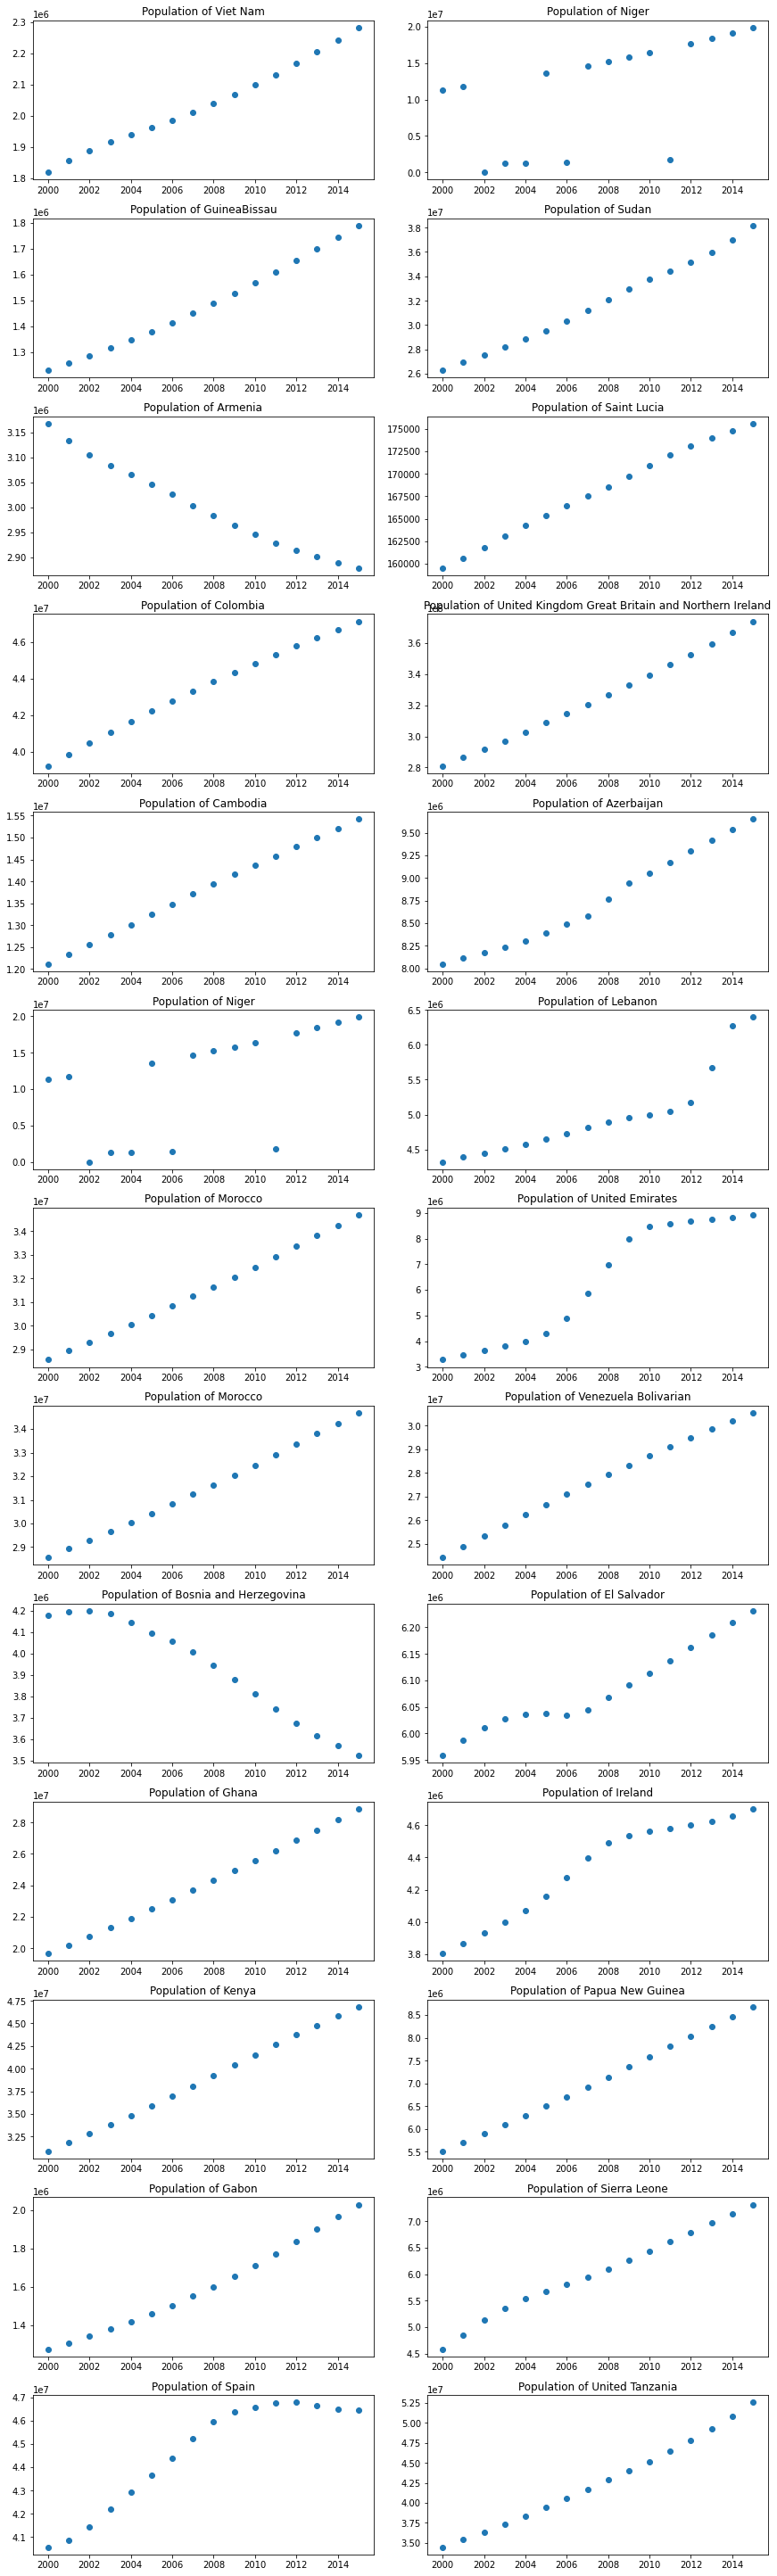

In [70]:
# Get random 26 countries
countries_to_analyze = merged_df['Country'].sample(n=26).values

# Per each country plot population.
x = y = 0 # coordinates for plot
fig, axs = plt.subplots(13, 2, figsize=(12, 40), constrained_layout=True)

for country in countries_to_analyze:
    # Get all 15 rows (15 years) for selected country
    df_country = merged_df[merged_df['Country'] == country]

    # Ploting data
    axs[x,y].set_title(f'Population of {country}')
    axs[x,y].scatter(df_country['Year'].astype(int), df_country['Population'])

    # Changing coordinates for ploting on next graph
    if y == 0:
        y = 1
    else:
        y = 0
        x += 1

#### GDP

In [71]:
gdp_df = pd.read_csv('/content/drive/MyDrive/Organizatii/Sigmoid/Padawan Learning/Exam/World_Bank_Data_GDP.csv', error_bad_lines=False, header=2)
gdp_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2727932960.89,2791061452.51,2963128491.62,2983798882.68,3092178770.95,3202234636.87,3368970253.05,2610038937.56,3126019399.06,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,21290811193.82,21808704493.26,23707266143.47,28210335256.20,26119063726.39,29682486700.37,...,983472863852.07,1003768056233.73,924522770394.56,882721265524.17,1021118730941.08,1007240479573.39,1001017049660.46,927484450967.31,1080711605709.63,NaN
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,537777811.11,548888895.56,546666677.78,751111191.11,800000044.44,1006666637.78,...,20564485419.17,20550582746.84,19998156214.40,18019558181.96,18896352021.94,18418848299.58,18904490262.91,20143442150.97,14786861638.45,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,10404135069.15,11127894641.02,11943187848.30,12676330764.69,13838369295.23,14862225759.91,...,832216894624.60,892497905712.37,766957955078.10,690545418736.16,683748014299.69,766359667820.70,794719102944.19,784799699387.38,840187283626.45,NaN
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,133401582620.49,137244439121.37,87219300384.51,49840491178.15,68972769395.63,77792944471.95,69309110145.77,53619073505.14,67404287260.32,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,6735731172.80,7074657898.23,6295820481.53,6682832632.28,7180813375.51,7878508502.60,7899879086.43,7716925356.13,9412034299.23,NaN
262,"Yemen, Rep.",YEM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,40415233436.18,43228585321.33,42444495590.11,31317828583.59,26842231204.80,21606161066.21,NaN,NaN,NaN,NaN
263,South Africa,ZAF,GDP (current US$),NY.GDP.MKTP.CD,8748596504.24,9225996313.48,9813996078.52,10854195662.88,11955995222.62,13068994777.89,...,400886013595.57,381198869776.11,346709790458.56,323585509674.48,381448814653.46,404159690890.85,388531954110.60,337619680138.49,419015018371.89,NaN
264,Zambia,ZMB,GDP (current US$),NY.GDP.MKTP.CD,713000000.00,696285714.29,693142857.14,718714285.71,839428571.43,1082857142.86,...,28037239462.71,27141023558.08,21251216798.78,20958412538.31,25873601260.84,26311590296.70,23308667781.23,18110631358.31,22147634727.36,NaN


In [72]:
# Get columns 
gdp_df.columns

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021',
       'Unnamed: 66'],
      dtype='object')

Now we can see that the graph above is smoother

In [73]:
# Drop Non-Usable columns
gdp_droped_df = gdp_df.drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 66'], axis=1)

# Drop Age-Columns that are out of our scope
gdp_droped_df = gdp_droped_df.drop(
    [i for i in gdp_droped_df.columns[1:] if int(i) < 2000 or int(i) > 2015],
    axis=1)

gdp_droped_df

,Country Name,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Aruba,1873184357.54,1896648044.69,1962011173.18,2044134078.21,2254748603.35,2359776536.31,2469832402.23,2677653631.28,2843016759.78,2553631284.92,2453631284.92,2637988826.82,2615083798.88,2727932960.89,2791061452.51,2963128491.62
1,Africa Eastern and Southern,283928427609.58,258821310851.57,264872614492.35,352662234006.59,438838435407.66,512216548337.93,575703116619.12,660804869868.71,708095438324.81,719071175011.08,860332378206.45,964180707358.46,972573424415.21,983472863852.07,1003768056233.73,924522770394.56
2,Afghanistan,NaN,NaN,3854235264.37,4539500884.05,5220823684.66,6226199249.32,6971379033.26,9715761649.79,10249767311.21,12154835707.90,15633856787.04,18190410820.62,20203572959.50,20564485419.17,20550582746.84,19998156214.40
3,Africa Western and Central,140410259302.46,146779813046.93,176605835909.85,204470860701.30,253471913925.27,310094246800.23,395655858340.01,464425613626.87,566479463919.37,507029514633.98,597129288864.78,680455985950.41,736039861278.13,832216894624.60,892497905712.37,766957955078.10
4,Angola,9129594818.61,8936063723.20,15285594828.42,17812704825.20,23552047248.43,36970918699.25,52381006892.04,65266452081.39,88538610805.32,70307166934.33,81699526880.81,109436566876.42,124998210652.24,133401582620.49,137244439121.37,87219300384.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5181776768.71,5015894692.97,5344014317.91,6341737193.76,6163785172.81,6735731172.80,7074657898.23,6295820481.53
262,"Yemen, Rep.",9652436179.65,9861560094.74,10694628091.67,11777966673.39,13872791658.55,16746344766.20,19061978586.13,21650532264.23,26910851361.76,25130274124.25,30906749533.22,32726417878.39,35401323349.88,40415233436.18,43228585321.33,42444495590.11
263,South Africa,151753369491.92,135429607036.66,129088132201.85,197020241490.08,255806631391.55,288868489078.99,303860874149.01,333075462599.71,316132138757.08,329753048857.05,417365076968.26,458201514136.98,434400545085.81,400886013595.57,381198869776.11,346709790458.56
264,Zambia,3600683039.73,4094480988.12,4193845678.17,4901839731.27,6221077674.78,8331870169.15,12756858899.28,14056957976.26,17910858637.90,15328342303.96,20265559483.85,23459515275.58,25503060420.03,28037239462.71,27141023558.08,21251216798.78


Need to create a new dataset, that will contains first row - name of the country, and second row - year, and third row population per that year.

In [74]:
new_df_gdp = gdp_droped_df.melt(id_vars=['Country Name'], value_vars=gdp_droped_df.columns[1:], var_name='Year', value_name='GDP')
new_df_gdp = new_df_gdp.rename(columns={'Country Name': 'Country'})
new_df_gdp['Year'] = new_df_gdp['Year'].astype(np.int64)

There are two datasets. They can contain name of the same country but written differently. Ex: "USA" and "United States of America" etc.

---
For handling this problem we will eliminate "noisy words" and will search for names that look like most similar between themselves. 

In [75]:
map_countries = {}

# Creating bag of words for names of the countries
bag_words = ['of', 'republic', 'islam', 'democratic', "peoples", 'arab', 'the']

def clear_words(name):
    # Clear from non-alpha symbols
    name = ''.join([i for i in name if i.isalpha() or i == ' '])
    return ' '.join(i for i in name.split() if i.lower() not in bag_words)

new_df_gdp['Country'] = new_df_gdp['Country'].apply(lambda x: clear_words(x))
df['Country'] = df['Country'].apply(lambda x: clear_words(x))


# Define a function that takes in a country name and returns the closest match
def match_name(name, list_of_names, min_score=0):
    match = process.extractOne(name, list_of_names, scorer=fuzz.token_sort_ratio)
    if match[1] > min_score:
        return match[0]
    else:
        return ""

# Create a new column in each DataFrame with matched country namesmatch_name
for country in df['Country'].unique():
    matched_name = match_name(country, new_df_gdp['Country'].unique())
    map_countries[matched_name] = country

In [76]:
# Create a new column in each DataFrame with matched country names
new_df_gdp['Matched Country'] = new_df_gdp['Country'].apply(lambda x: map_countries.get(x))

# Merge the DataFrames on the matched country names column
merged_df = pd.merge(df, new_df_gdp, left_on=['Country', 'Year'], right_on=['Matched Country', 'Year'], how='left')

# update the GDP column
merged_df['GDP'] = merged_df['GDP_y']
merged_df['GDP'] = np.where(merged_df['GDP'].isnull(), merged_df['GDP_x'], merged_df['GDP_y'])

merged_df = merged_df.rename(columns = {'Country_x' : 'Country'})
df = merged_df.drop(columns=['GDP_x', 'GDP_y', 'Matched Country', 'Country_y'])

Ploting new data

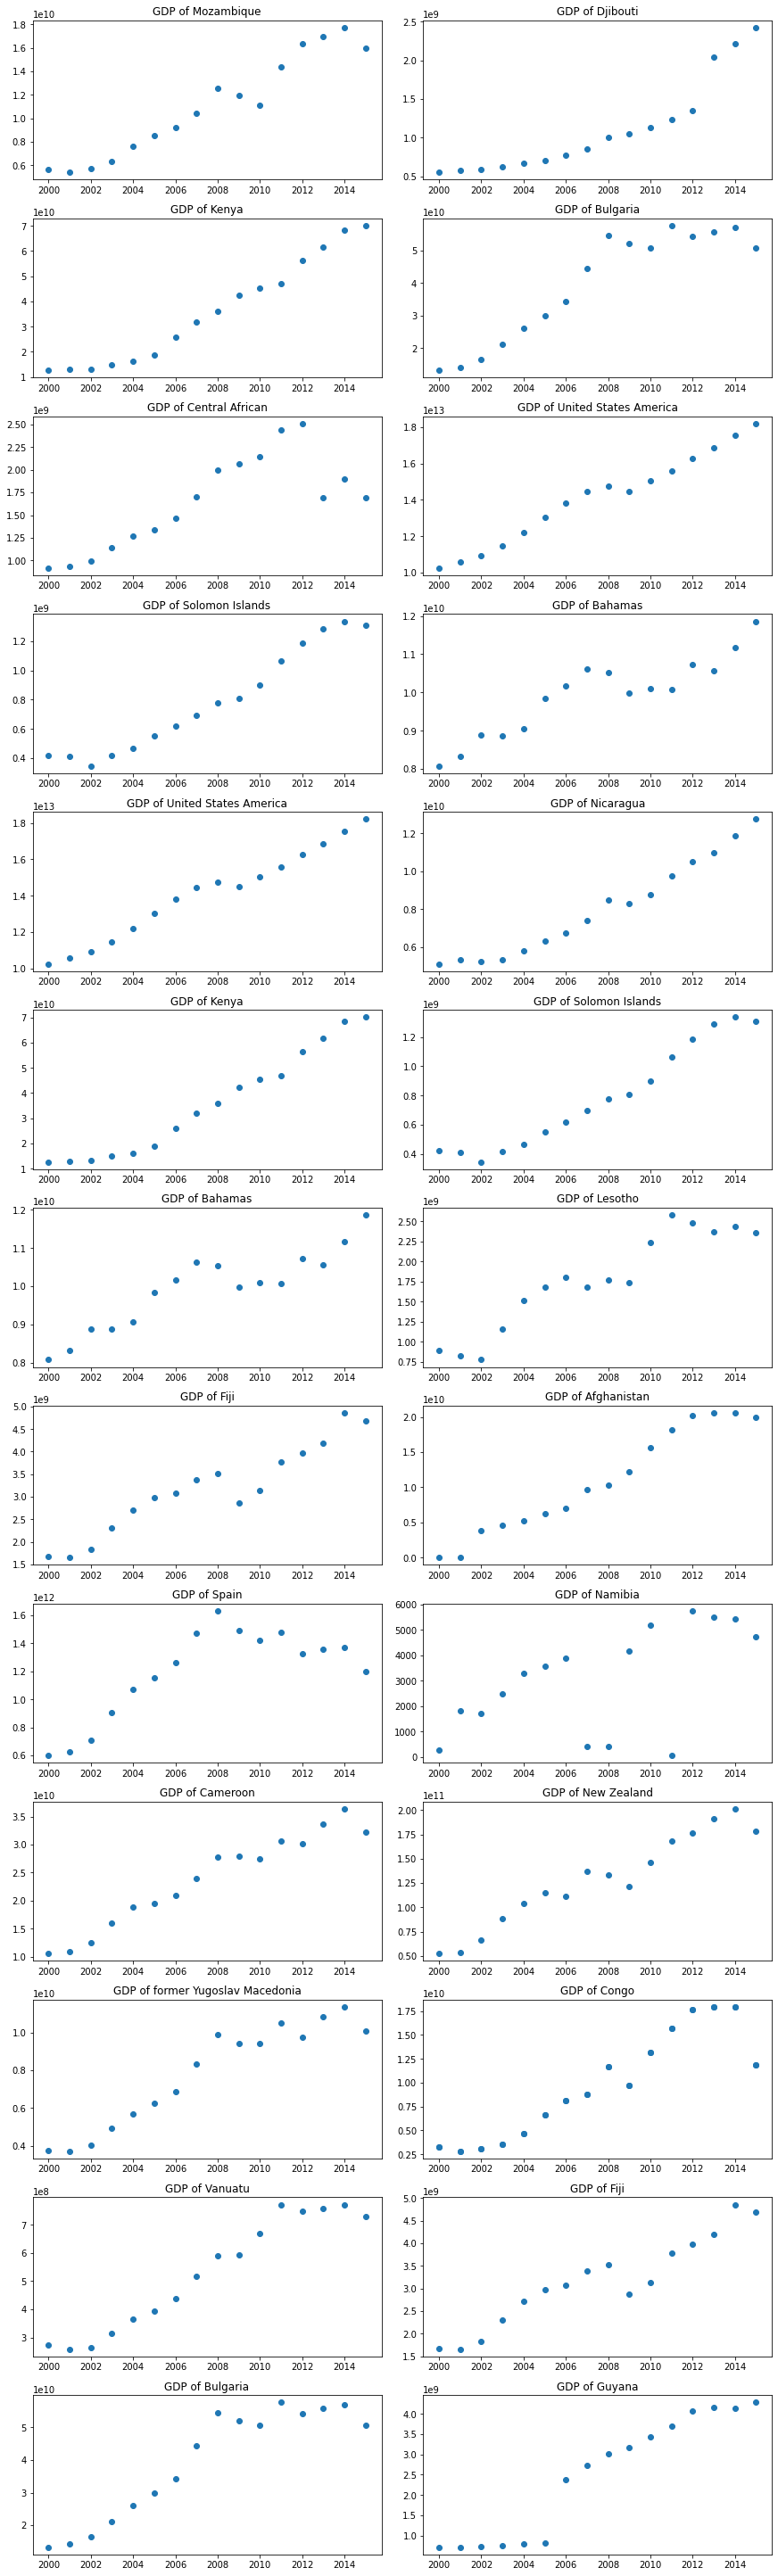

In [77]:
# Get random 26 countries
countries_to_analyze = merged_df['Country'].sample(n=26).values

# Per each country plot GDP.

x = y = 0 # coordinates for plot
fig, axs = plt.subplots(13, 2, figsize=(12, 40), constrained_layout=True)

for country in countries_to_analyze:
    # Get all 15 rows (15 years) for selected country
    df_country = merged_df[merged_df['Country'] == country]

    # Ploting data
    axs[x,y].set_title(f'GDP of {country}')
    axs[x,y].scatter(df_country['Year'].astype(int), df_country['GDP'])

    # Changing coordinates for ploting on next graph
    if y == 0:
        y = 1
    else:
        y = 0
        x += 1

## Dealing with categorical data

In [78]:
# One hot encoding "Status" column
df['Status'] = pd.get_dummies(df['Status'].values, drop_first=True).values

In [79]:
df

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,Income composition of resources,Schooling,Population,GDP
0,Afghanistan,2015,1,65.00,263.00,62,0.01,71.28,65.00,1154,...,83,6.00,8.16,65.00,0.10,17.20,0.48,10.10,33753499.00,19998156214.40
1,Afghanistan,2014,1,59.90,271.00,64,0.01,73.52,62.00,492,...,86,58.00,8.18,62.00,0.10,17.50,0.48,10.00,32716210.00,20550582746.84
2,Afghanistan,2013,1,59.90,268.00,66,0.01,73.22,64.00,430,...,89,62.00,8.13,64.00,0.10,17.70,0.47,9.90,31541209.00,20564485419.17
3,Afghanistan,2012,1,59.50,272.00,69,0.01,78.18,67.00,2787,...,93,67.00,8.52,67.00,0.10,17.90,0.46,9.80,30466479.00,20203572959.50
4,Afghanistan,2011,1,59.20,275.00,71,0.01,7.10,68.00,3013,...,97,68.00,7.87,68.00,0.10,18.20,0.45,9.50,29249157.00,18190410820.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,1,44.30,723.00,27,4.36,0.00,68.00,31,...,42,67.00,7.13,65.00,33.60,9.40,0.41,9.20,12160881.00,5805598400.00
2934,Zimbabwe,2003,1,44.50,715.00,26,4.06,0.00,7.00,998,...,41,7.00,6.52,68.00,36.70,9.80,0.42,9.50,12075828.00,5727591800.00
2935,Zimbabwe,2002,1,44.80,73.00,25,4.43,0.00,73.00,304,...,40,73.00,6.53,71.00,39.80,1.20,0.43,10.00,11984644.00,6342116400.00
2936,Zimbabwe,2001,1,45.30,686.00,25,1.72,0.00,76.00,529,...,39,76.00,6.16,75.00,42.10,1.60,0.43,9.80,11910978.00,6777384700.00


## Spliting in Test and train

In [80]:
y = df['Life expectancy']
X = df.drop(['Life expectancy'], axis=1)

# Split in train/test

from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(df, test_size=0.3, random_state=25)

In [81]:
# For better accuracy delete nan values from testing data
testing_data = testing_data.dropna()

## Dealing with NaN values

In [82]:
training_data.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                      8
Adult Mortality                      8
infant deaths                        0
Alcohol                            142
percentage expenditure               0
Hepatitis B                        395
Measles                              0
BMI                                 27
under-five deaths                    0
Polio                               17
Total expenditure                  166
Diphtheria                          17
HIV/AIDS                             0
thinness  1-19 years                27
Income composition of resources    117
Schooling                          114
Population                           0
GDP                                 23
dtype: int64

In [83]:
training_data[training_data['Hepatitis B'].isna()]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,Income composition of resources,Schooling,Population,GDP
2767,United Kingdom Great Britain and Northern Ireland,2010,0,82.00,77.00,3,10.88,0.00,NaN,443,...,4,94.00,9.51,94.00,0.10,0.80,NaN,NaN,339527169.00,1570449574113.68
2615,TimorLeste,2001,1,59.40,269.00,3,0.50,6.56,NaN,0,...,4,NaN,3.75,NaN,0.10,12.10,0.47,9.80,893001.00,477443500.00
1779,Mozambique,2000,1,49.00,43.00,93,1.14,47.17,NaN,7375,...,136,69.00,6.16,7.00,12.20,4.20,0.29,5.40,17768505.00,5656473652.41
1803,Namibia,2008,1,61.70,317.00,3,6.28,59.55,NaN,0,...,4,83.00,7.15,83.00,11.70,11.50,0.59,11.30,216375.00,429.66
1166,Hungary,2003,0,72.50,184.00,1,13.24,1030.22,NaN,0,...,1,99.00,8.42,99.00,0.10,2.10,0.78,14.90,10129552.00,85285062818.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,Hungary,2009,0,74.20,162.00,0,11.46,1281.16,NaN,1,...,1,99.00,7.55,99.00,0.10,1.80,0.82,15.30,10022650.00,131069255620.57
765,Djibouti,2003,1,58.00,325.00,2,1.02,94.13,NaN,37,...,2,68.00,6.22,68.00,4.20,6.10,0.38,3.50,806411.00,622044665.52
1175,Iceland,2010,0,81.80,53.00,0,8.25,6005.58,NaN,0,...,0,96.00,8.86,96.00,0.10,0.90,0.89,18.40,318041.00,13751161917.74
2522,Switzerland,2014,0,83.20,51.00,0,9.61,19479.91,NaN,23,...,0,96.00,11.66,96.00,0.10,0.40,0.94,15.90,8188649.00,726537808338.00


There is a problem with NaN values at "Hepatitis B " columns. Practically 25% of our dataset does not have this data.


---

From the above cell we can conclude that there is a big variation between minimum and maximum value. That's why we will get mean value based on country Status and Life Expectancy of others countries

In [84]:
# Filling missing data by grouping by country and filling with mean using previous/future values
grouped =  training_data.groupby(["Country", "Year"])

# Fill the missing values  with the calculated mean for the same country
training_data["Alcohol"] =  training_data.groupby(["Country"])["Alcohol"].apply(lambda x: x.fillna(x.mean()))
# Fill the missing values in the 'Total expenditure' column with the calculated mean
training_data['Total expenditure'] =  training_data.groupby(["Country"])['Total expenditure'].apply(lambda x: x.fillna(x.mean()))
training_data['GDP'] =  training_data.groupby(["Country"])['GDP'].apply(lambda x: x.fillna(x.mean()))
training_data['Schooling'] =  training_data.groupby(["Country"])['Schooling'].apply(lambda x: x.fillna(x.mean()))

In [85]:
training_data['Life expectancy group'] = pd.cut( training_data['Life expectancy'], bins=[0,30,35,40,45,50,55,60, 65, 70, 75, 80, 85, 90, 100], labels=['0-30','30-35','35-40','40-45','45-50','50-55','55-60','60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-100'])

# Group the dataframe by "Status" and "Life expectancy group"
grouped =  training_data.groupby(['Status', 'Life expectancy group'])

# Fill NaN values in columns with mean of the group
training_data['Total expenditure'] = grouped['Total expenditure'].transform(lambda x: x.fillna(x.mean()))
training_data['Diphtheria'] = grouped['Diphtheria'].transform(lambda x: x.fillna(x.mean()))
training_data['thinness  1-19 years'] = grouped['thinness  1-19 years'].transform(lambda x: x.fillna(x.mean()))
training_data['Income composition of resources'] = grouped['Income composition of resources'].transform(lambda x: x.fillna(x.mean()))
training_data['Schooling'] = grouped['Schooling'].transform(lambda x: x.fillna(x.mean()))
training_data['BMI'] = grouped['BMI'].transform(lambda x: x.fillna(x.mean()))
training_data['Polio'] = grouped['Polio'].transform(lambda x: x.fillna(x.mean()))
training_data['Hepatitis B'] = grouped['Hepatitis B'].transform(lambda x: x.fillna(x.mean()))

In [86]:
training_data[training_data['Hepatitis B'].isna()]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,thinness 1-19 years,Income composition of resources,Schooling,Population,GDP,Life expectancy group
2713,Tuvalu,2013,1,NaN,NaN,0,0.01,78.28,NaN,0,...,NaN,NaN,NaN,0.10,NaN,NaN,NaN,10918.00,38617493.72,NaN
1650,Marshall Islands,2013,1,NaN,NaN,0,0.01,871.88,NaN,0,...,NaN,NaN,NaN,0.10,NaN,NaN,NaN,51352.00,185468000.00,NaN
2167,Saint Kitts and Nevis,2013,1,NaN,NaN,0,8.54,0.00,NaN,0,...,NaN,NaN,NaN,0.10,NaN,NaN,NaN,47767.00,875376407.41,NaN
1812,Nauru,2013,1,NaN,NaN,0,0.01,15.61,NaN,0,...,NaN,NaN,NaN,0.10,NaN,NaN,NaN,10694.00,98491843.64,NaN
1958,Palau,2013,1,NaN,NaN,0,NaN,344.69,NaN,0,...,NaN,NaN,NaN,0.10,NaN,NaN,NaN,17805.00,221117200.00,NaN
624,Cook Islands,2013,1,NaN,NaN,0,0.01,0.00,NaN,0,...,NaN,NaN,NaN,0.10,NaN,NaN,NaN,48418.00,2690116268.72,NaN
1909,Niue,2013,1,NaN,NaN,0,0.01,0.00,NaN,0,...,NaN,NaN,NaN,0.10,NaN,NaN,NaN,18653199.00,10224897934.72,NaN
1715,Monaco,2013,1,NaN,NaN,0,0.01,0.00,NaN,0,...,NaN,NaN,NaN,0.10,NaN,NaN,NaN,35425.00,6555983530.35,NaN


We can see that majority of Hepatitis B  NaN value dissapeared, but there also remained 8 examples

We can see that rows that have missing value in Hepatitics B column have also missing value in others very important columns (Life expectancy, Adult Mortality, etc.)


In [87]:
training_data =  training_data.dropna(subset=['Hepatitis B', 'Diphtheria'])
training_data["Alcohol"] =  training_data["Alcohol"].fillna(0)
training_data.isna().sum()

Country                            0
Year                               0
Status                             0
Life expectancy                    0
Adult Mortality                    0
infant deaths                      0
Alcohol                            0
percentage expenditure             0
Hepatitis B                        0
Measles                            0
BMI                                0
under-five deaths                  0
Polio                              0
Total expenditure                  0
Diphtheria                         0
HIV/AIDS                           0
thinness  1-19 years               0
Income composition of resources    0
Schooling                          0
Population                         0
GDP                                0
Life expectancy group              0
dtype: int64

In [88]:
# Drop "Life expectancy group"
training_data.drop(['Life expectancy group'], axis=1, inplace=True)

In [89]:
# Drop Country column
training_data = training_data.drop(['Country'], axis=1)
testing_data = testing_data.drop(['Country'], axis=1)

## Separating X and y

In [90]:
y_train = training_data['Life expectancy'].values
X_train = training_data.drop(['Life expectancy'], axis=1)

y_test = testing_data['Life expectancy'].values
X_test = testing_data.drop(['Life expectancy'], axis=1)

## Feature Engineering

In [91]:
from sklearn.preprocessing import MinMaxScaler
scaller = MinMaxScaler()

In [92]:
# Fit transform data
scaller.fit(X_train)

# Transform data
X_train = scaller.transform(X_train)
X_test= scaller.transform(X_test)

# Training model

In [93]:
!pip install lazypredict
from lazypredict.Supervised import LazyRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
reg = LazyRegressor(predictions=True)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models

 90%|█████████ | 38/42 [03:51<00:44, 11.04s/it]

[22:01:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 42/42 [03:51<00:00,  5.52s/it]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.96,0.97,1.56,1.10
LGBMRegressor,0.96,0.96,1.72,0.29
RandomForestRegressor,0.96,0.96,1.72,2.05
BaggingRegressor,0.95,0.95,1.81,0.23
HistGradientBoostingRegressor,0.95,0.95,1.82,1.24
XGBRegressor,0.93,0.94,2.12,0.28
GradientBoostingRegressor,0.93,0.94,2.13,0.82
DecisionTreeRegressor,0.90,0.90,2.59,0.07
ExtraTreeRegressor,0.89,0.90,2.70,0.07
